In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from keras.models import Sequential
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import model_from_json
import pickle

In [30]:
import pandas as pd

# Load your dataset
df = pd.read_csv('Depression_EEG.csv')

# Method 1: Remove rows with any null values
df_cleaned = df.dropna()

# Method 2: Fill null values with the mean of the column
df_filled = df.fillna(df.mean())

# Method 3: Interpolation (fill using neighboring values)
df_interpolated = df.interpolate()

# Save the cleaned dataset
df_cleaned.to_csv('Depression_EEG_cleaned.csv', index=False)


In [31]:
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict, average='macro') * 100
    r = recall_score(testY, predict, average='macro') * 100
    f = f1_score(testY, predict, average='macro') * 100
    a = accuracy_score(testY, predict) * 100
    conf_matrix = confusion_matrix(testY, predict)
    
    print(f"{algorithm} Accuracy    : {a}")
    print(f"{algorithm} Precision   : {p}")
    print(f"{algorithm} Recall      : {r}")
    print(f"{algorithm} FScore      : {f}\n")
    
    labels = ['Normal', 'Depressed']
    plt.figure(figsize=(6, 6))
    ax = sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, cmap="viridis", fmt="g")
    ax.set_ylim([0, 2])
    plt.title(f"{algorithm} Confusion Matrix")
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()

In [32]:
import numpy as np
import os
import pickle
from sklearn.model_selection import train_test_split
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical

def runCNN(X, Y):
    # Reshape and preprocess the data
    X = X[:, 0:972]  # Adjust based on your features
    XX = X.reshape(X.shape[0], 18, 18, 3)  # Reshape according to your dimensions
    YY = to_categorical(Y)

    # Split data into training and testing sets
    X_train1, X_test1, y_train1, y_test1 = train_test_split(XX, YY, test_size=0.2)

    # Check if the model exists
    if os.path.exists('model.json'):
        with open('model.json', "r") as json_file:
            loaded_model_json = json_file.read()
            cnn = model_from_json(loaded_model_json)
        cnn.load_weights("model_weights.h5")
    else:
        # Build the CNN model
        cnn = Sequential()
        cnn.add(Conv2D(64, (3, 3), input_shape=(X_train1.shape[1], X_train1.shape[2], X_train1.shape[3]), activation='relu'))
        cnn.add(MaxPooling2D(pool_size=(2, 2)))
        cnn.add(Conv2D(64, (3, 3), activation='relu'))
        cnn.add(MaxPooling2D(pool_size=(2, 2)))
        cnn.add(Conv2D(64, (3, 3), activation='relu'))
        cnn.add(MaxPooling2D(pool_size=(2, 2)))
        cnn.add(Conv2D(64, (3, 3), activation='relu'))
        cnn.add(MaxPooling2D(pool_size=(2, 2)))
        cnn.add(Flatten())
        cnn.add(Dense(units=256, activation='relu'))
        cnn.add(Dense(units=y_test1.shape[1], activation='softmax'))
        cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Train the model
        hist = cnn.fit(X_train1, y_train1, batch_size=16, epochs=100, shuffle=True, verbose=2, validation_data=(X_test1, y_test1))
        
        # Save model weights and architecture
        cnn.save_weights('model_weights.h5')
        model_json = cnn.to_json()
        with open("model.json", "w") as json_file:
            json_file.write(model_json)
        
        # Save training history
        with open('history.pckl', 'wb') as f:
            pickle.dump(hist.history, f)

    # Print CNN summary
    print(cnn.summary())

    # Predict and calculate metrics
    predict = cnn.predict(X_test1)
    predict = np.argmax(predict, axis=1)
    testY = np.argmax(y_test1, axis=1)
    
    # Assuming calculateMetrics is defined elsewhere
    calculateMetrics("CNN", predict, testY)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 16, 16, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 6, 6, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │          73,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 253,928 (991.91 KB)

 Trainable params: 84,642 (330.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 169,286 (661.28 KB)

None
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
CNN Accuracy    : 59.2741935483871
CNN Precision   : 44.22568322068763
CNN Recall      : 60.21594684385382
CNN FScore      : 49.95258061295797



C:\Users\bussa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


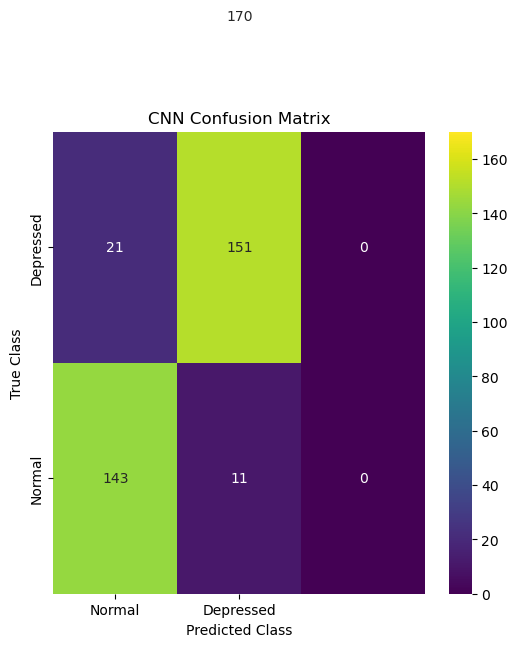

In [35]:

def load_and_train():
    # Update the path to the actual dataset file
    dataset = pd.read_csv('Depression_EEG_cleaned.csv')
    
    # Preprocess data
    dataset = dataset.values
    X = dataset[:, 0:dataset.shape[1]-1]
    Y = dataset[:, dataset.shape[1]-1]

    # Run CNN model
    runCNN(X, Y)

# Call the function to load data and train the CNN model
load_and_train()


Number of samples: 2479, Number of features: 988
Reshaped data into: (2479, 38, 26, 1)
Resized data shape: (2479, 32, 32)
RGB data shape: (2479, 32, 32, 3)
Categorical labels shape: (2479, 3)
Train data shape: (1983, 32, 32, 3), Train labels shape: (1983, 3)
Test data shape: (496, 32, 32, 3), Test labels shape: (496, 3)
Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 357s 317ms/step - accuracy: 0.6040 - loss: 0.9449 - val_accuracy: 0.4758 - val_loss: 1.0295
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 33s 268ms/step - accuracy: 0.7364 - loss: 0.5890 - val_accuracy: 0.6452 - val_loss: 0.8890
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 39s 311ms/step - accuracy: 0.8308 - loss: 0.4545 - val_accuracy: 0.7944 - val_loss: 0.6234
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 37s 295ms/step - accuracy: 0.8391 - loss: 0.4194 - val_accuracy: 0.8286 - val_loss: 0.9403
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 34s 278ms/step - accuracy: 0.8812 - loss: 0.3193 - val_accuracy: 0.8185 - val_loss: 0.6246
Epoch 6/10
124/124 ━━━

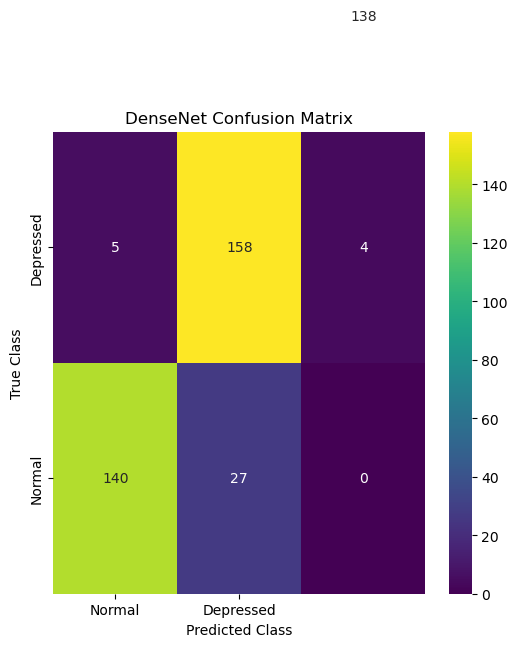

In [36]:
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

# Load your dataset (replace with your actual loading method)
# df = pd.read_csv('your_dataset.csv')
# Assuming the dataset is loaded into X and y
X = df.iloc[:, :-1].values  # Features
y = df.iloc[:, -1].values    # Labels

# Scale the data (e.g., using StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data (number of samples, height, width, channels)
num_samples, num_features = X_scaled.shape
height, width = 38, 26  # Original reshape dimensions

# Check that num_features can be reshaped correctly
print(f"Number of samples: {num_samples}, Number of features: {num_features}")

# Ensure the total number of features is equal to height * width
if num_features != height * width:
    raise ValueError(f"Cannot reshape: {num_features} != {height * width}")

# Reshape the data into a 4D array
X_reshaped = X_scaled.reshape(-1, height, width, 1)
print(f"Reshaped data into: {X_reshaped.shape}")

# Resize images to 32x32
X_resized = np.array([cv2.resize(image.squeeze(), (32, 32)) for image in X_reshaped])
print(f"Resized data shape: {X_resized.shape}")

# Convert grayscale images to 3 channels
X_resized_rgb = np.repeat(X_resized[..., np.newaxis], 3, axis=-1)
print(f"RGB data shape: {X_resized_rgb.shape}")

# Convert labels to categorical format
y_categorical = to_categorical(y)
print(f"Categorical labels shape: {y_categorical.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resized_rgb, y_categorical, test_size=0.2, random_state=42)
print(f"Train data shape: {X_train.shape}, Train labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")

# Build DenseNet model
densenet_base = DenseNet121(include_top=False, input_shape=(32, 32, 3), weights=None)

model = Sequential()
model.add(densenet_base)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16)


test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc * 100:.2f}%')
predict =model.predict(X_test)
predict = np.argmax(predict, axis=1)
testY = np.argmax(y_test, axis=1)
calculateMetrics("DenseNet", predict, testY)


In [ ]:
import pickle
with open('dense_history.pckl', 'wb') as f:
    pickle.dump(dense_hist.history, f)
